In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import time
import numpy as np

import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from cleverhans.utils_tf import batch_eval
from cleverhans.dataset import CIFAR10
from dataloader import SVHN

from utils_config import ModelConfig, dataset_loader
from utils_experiment import get_data_dict
from utils_experiment import train_model
from utils_experiment import hyperparameter_selection
from dknn import DkNNModel, NearestNeighbor

from matplotlib import pyplot as plt
import copy
from PIL import Image
import scipy.io

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
mc = ModelConfig(config_file='../configs/config_mnist.yaml',
                 root_dir='../results/')

In [4]:
# train_model(mc)

In [5]:
import copy

# reand and wrangle data
data_dict = get_data_dict(mc)

# parse data_dict
x_train = data_dict['x_train'] 
y_train = data_dict['labels_train']
x_test = data_dict['x_test']
y_test = data_dict['y_test']
x_cali = data_dict['x_cali'] 
y_cali = data_dict['labels_cali']

# Use Image Parameters.
img_rows, img_cols, nchannels = x_train.shape[1:4]

# Use a holdout of the test set to simulate calibration data for the DkNN.
train_data = x_train
train_labels = y_train

# Get rotated MNIST
x_rotated = copy.copy(x_test)
y_rotated = copy.copy(y_test)

for i, x in enumerate(x_rotated):
    im = Image.fromarray(np.uint8(x[:,:,0]*255), mode='L')
    im = im.rotate(45)
    x_rotated[i,:,:,0] = np.array(im)/255

# Get Not MNIST
nm_file = '../data/notMNIST_small.mat'
if not os.path.exists(nm_file):
    url = 'http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat'
    print('downloading Not MNIST data to {}'.format(nm_file))
    with urllib.request.urlopen(url) as response, open(nm_file, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
mat = scipy.io.loadmat(nm_file)
nm = mat['images'][:,:,:250].transpose(2,0,1).reshape(-1,28,28,1)

print(x_test.shape)
print(x_rotated.shape)
print(nm.shape)

(250, 28, 28, 1)
(250, 28, 28, 1)
(250, 28, 28, 1)


In [6]:
# Use Image Parameters.
img_rows, img_cols, nchannels = x_train.shape[1:4]

with mc.get_tensorflow_session() as sess:
    with tf.variable_scope('dknn'):
        # Define input TF placeholder.
        x = tf.placeholder(tf.float32,
                        shape=(None, img_rows, img_cols, nchannels))
        #y = tf.placeholder(tf.float32,
        #                  shape=(None, mc.nb_classes))

        model_dir = mc.get_model_dir_name()
        model = mc.load_model(model_dir=model_dir)

        # Define callable that returns a dictionary of all activations for a dataset
        def get_activations(data):
            data_activations = {}
            for layer in layers:
                layer_sym = tf.layers.flatten(model.get_layer(x, layer))
                data_activations[layer] = batch_eval(sess, [x], [layer_sym], [data],
                                                args={'batch_size': mc.batch_size})[0]
            return data_activations

        # Extract representations for the training and calibration data at each layer of interest to the DkNN.
        layers = ['ReLU1', 'ReLU3', 'ReLU5', 'logits']

        #Euclidean DKNN
        dknn = DkNNModel(
        neighbors = mc.nb_neighbors,
        proto_neighbors = mc.nb_proto_neighbors,
        backend = mc.backend,
        nb_classes=mc.nb_classes,
        layers=layers,
        get_activations=get_activations,
        train_data=x_train,
        train_labels=y_train,
        method='euclidean',
        scope='dknn')

        dknn.fit()
        dknn.calibrate(x_cali, y_cali)

        # Geodesic DKNN
        dknn_geod = DkNNModel(
        neighbors = mc.nb_neighbors,
        proto_neighbors = mc.nb_proto_neighbors,
        backend = mc.backend,
        nb_classes=mc.nb_classes,
        layers=layers,
        get_activations=get_activations,
        train_data=x_train,
        train_labels=y_train,
        method='geodesic',
        neighbors_table_path=os.path.join(mc.get_model_dir_name(),'geodesics'),
        scope='dknn')

        dknn_geod.fit()
        dknn_geod.calibrate(x_cali, y_cali)
        
        
        
        print('Getting confidence scores')
        preds_knn, conf_euc, cred_euc = dknn.predict(x_test)
        preds_geod, conf_geo, cred_geo = dknn_geod.predict(x_test)
        
        preds_knn, conf_euc_rotated, cred_euc_rotated = dknn.predict(x_rotated)
        preds_geod, conf_geo_rotated, cred_geo_rotated = dknn_geod.predict(x_rotated)
        
        preds_knn, conf_euc_nm, cred_euc_nm = dknn.predict(nm)
        preds_geod, conf_geo_nm, cred_geo_nm = dknn_geod.predict(nm)
        
        conf_softmax = []
        conf_dknn = [conf_euc.max(axis=1), conf_euc_rotated.max(axis=1), conf_euc_nm.max(axis=1)]
        conf_geod = [conf_geo.max(axis=1), conf_geo_rotated.max(axis=1), conf_geo_nm.max(axis=1)]
        cred_softmax = []
        cred_dknn = [cred_euc.max(axis=1), cred_euc_rotated.max(axis=1), cred_euc_nm.max(axis=1)]
        cred_geod = [cred_geo.max(axis=1), cred_geo_rotated.max(axis=1), cred_geo_nm.max(axis=1)]
        print('Getting activations')
        conf_softmax.append(get_activations(x_test)['logits'])
        conf_softmax.append(dknn.get_activations(x_rotated)['logits'])
        conf_softmax.append(dknn.get_activations(nm)['logits'])
        
        cred_softmax.append(dknn.get_activations(x_test)['logits'])
        cred_softmax.append(dknn.get_activations(x_rotated)['logits'])
        cred_softmax.append(dknn.get_activations(nm)['logits'])


Reading model from:
 ../results/MNIST/nb_train_5000_lr_0.001_bs_2_1/model.joblib


/home/ye/anaconda3/envs/gdknn/lib/python3.6/site-packages/cleverhans/utils_tf.py:294: UserWarning: batch_eval has moved to cleverhans.evaluation. batch_eval will be removed from utils_tf on or after 2019-03-09.
  warnings.warn("batch_eval has moved to cleverhans.evaluation. "
/home/ye/anaconda3/envs/gdknn/lib/python3.6/site-packages/cleverhans/evaluation.py:376: UserWarning: `args` is deprecated and will be removed on or after 2019-03-09. Pass `batch_size` directly.
  warnings.warn("`args` is deprecated and will be removed on or "


Constructing the NearestNeighbor table
Constructing the NearestNeighbor table
Constructing the NearestNeighbor table
Constructing the NearestNeighbor table
Starting calibration.
DkNN calibration complete.
Constructing the NearestNeighborGeodesic table
Constructing the NearestNeighborGeodesic table
Constructing the NearestNeighborGeodesic table
Constructing the NearestNeighborGeodesic table
Starting calibration.
DkNN calibration complete.
Getting confidence scores
Predicting.
Prediction complete.
Predicting.
Prediction complete.
Predicting.
Prediction complete.
Predicting.
Prediction complete.
Predicting.
Prediction complete.
Predicting.
Prediction complete.
Getting activations


In [7]:
aaa = copy.copy(conf_softmax)
conf_softmax = [(1/(1+np.exp(-c))).max(axis=1) for c in conf_softmax]
bbb = copy.copy(cred_softmax)
cred_softmax = [(1/(1+np.exp(-c))).max(axis=1) for c in cred_softmax]

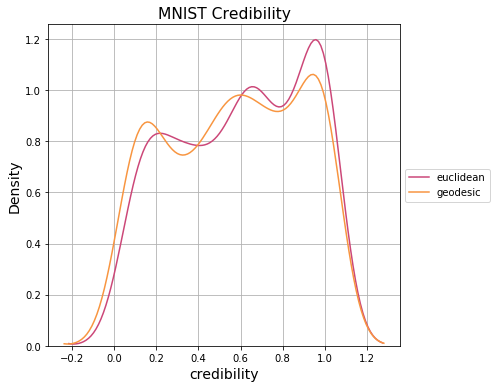

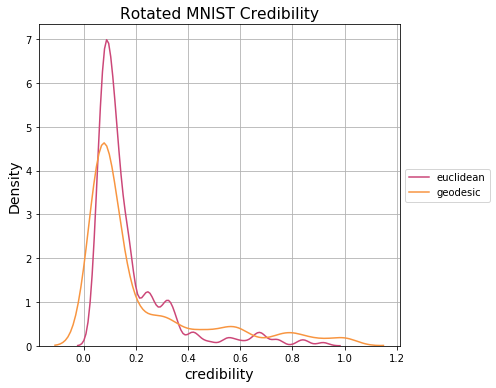

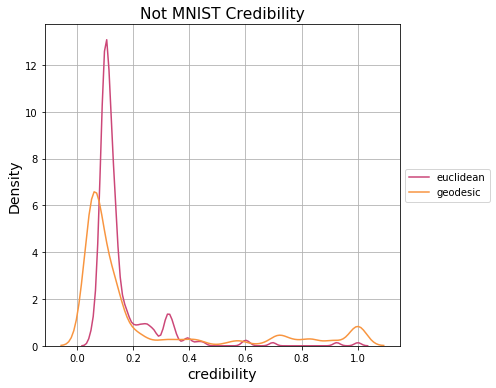

In [16]:
import seaborn as sns
def plot_distributions(distributions_dict, xlabel, fig_title):
    n_distributioins = len(distributions_dict.keys())
    fig, ax = plt.subplots(1, figsize=(7,5.5))
    plt.subplots_adjust(wspace=0.35)
    colors = sns.color_palette('plasma', len(distributions_dict.keys()))
    
    for idx, dist_name in enumerate(distributions_dict.keys()):
        if idx == 0:
            continue
#         cur = np.histogram(distributions_dict[dist_name], bins=10, range=(0,1),density=True)
#         print(cur)
        train_dist_plot = sns.kdeplot(distributions_dict[dist_name],
                                     bw='silverman',
                                     label=dist_name,
                                     color=colors[idx])
#         train_dist_plot = sns.distplot(distributions_dict[dist_name], hist=False, rug=True,
#                                      label=dist_name, color=colors[idx])
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Density', fontsize=14)
        ax.set_title(fig_title, fontsize=15.5)
        ax.grid(True)
        ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    fig.tight_layout()
    plt.show()
    
confs = []
for i in range(len(conf_softmax)):
    confs.append(
                {
                'softmax':conf_softmax[i],
                'euclidean':conf_dknn[i],
                'geodesic':conf_geod[i],
            })
creds = []
for i in range(len(conf_softmax)):
    creds.append(
                {
                'softmax':cred_softmax[i],
                'euclidean':cred_dknn[i],
                'geodesic':cred_geod[i],
            })
# plot_distributions(confs[0], 'confidence', 'MNIST Confidence')
plot_distributions(creds[0], 'credibility', 'MNIST Credibility')
# plot_distributions(confs[1], 'confidence', 'Rotated MNIST Confidence')
plot_distributions(creds[1], 'credibility', 'Rotated MNIST Credibility')
# plot_distributions(confs[2], 'confidence', 'Not MNIST Confidence')
plot_distributions(creds[2], 'credibility', 'Not MNIST Credibility')

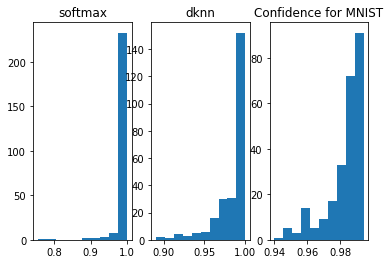

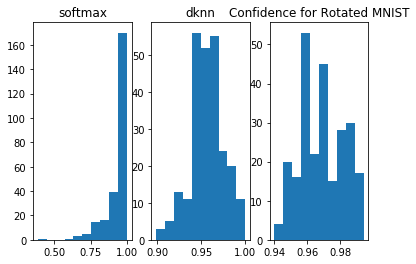

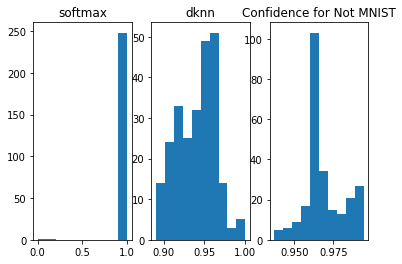

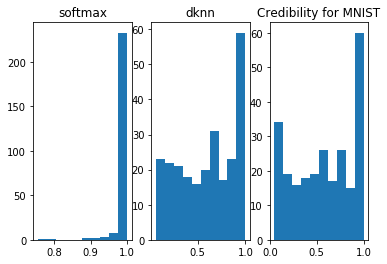

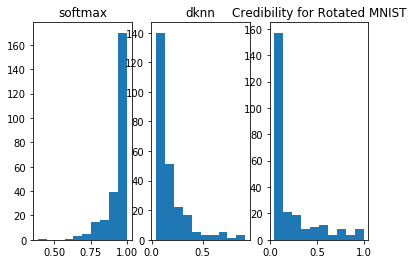

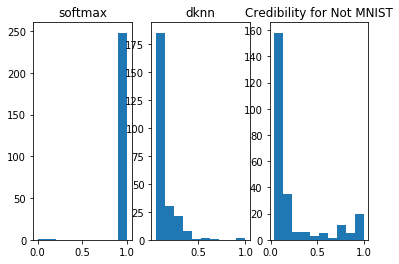

In [13]:
dic = {0: 'MNIST', 1:'Rotated MNIST', 2:'Not MNIST'}

for i in range(len(conf_softmax)):
#     print(conf_softmax[i].shape)
#     print(conf_dknn[i].shape)
#     print(conf_geod[i].shape)
    fig, ax = plt.subplots(1,3)
    ax[0].hist(conf_softmax[i])
    ax[0].set_title('softmax')
    ax[1].hist(conf_dknn[i])
    ax[1].set_title('dknn')
    ax[2].hist(conf_geod[i])
    ax[2].set_title('geod')
    plt.title('Confidence for {}'.format(dic[i]))
#     plt.savefig('{}.png'.format(dic[i]))
    plt.show()
    
for i in range(len(cred_softmax)):
#     print(conf_softmax[i].shape)
#     print(conf_dknn[i].shape)
#     print(conf_geod[i].shape)
    fig, ax = plt.subplots(1,3)
    ax[0].hist(cred_softmax[i])
    ax[0].set_title('softmax')
    ax[1].hist(cred_dknn[i])
    ax[1].set_title('dknn')
    ax[2].hist(cred_geod[i])
    ax[2].set_title('geod')
    plt.title('Credibility for {}'.format(dic[i]))
#     plt.savefig('{}.png'.format(dic[i]))
    plt.show()
